<a href="https://colab.research.google.com/github/JTT94/neural_processes/blob/valerie-working/NeuralProcess_vb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from importlib import reload
from tqdm import tqdm_notebook
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ExpSineSquared

# import functions 
from functions import *
from nn_architecture import *
from NeuralProcess import *
from predictNP import *




# Neural Processes

Goal: Combine benefits of Gaussian processes (distribution over functions) and neural networks (flexibility, no assumption of kernel type)

Replicating work from Kaspar Martens' [blog post](https://kasparmartens.rbind.io/post/np/) on Neural Processes with help translating to Python from Sander van Dijk's [GitHub repo](https://github.com/sgvandijk/neural-processes).


## Demonstrate Gaussian Process regression

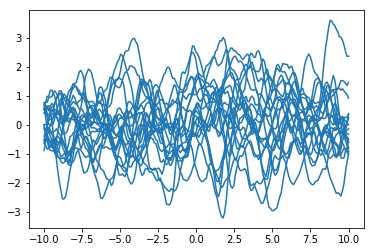

In [2]:
# generate data from GP

# intialize GP with Matern kernel
gp = GaussianProcessRegressor(Matern())

# generate Xs
xs = np.linspace(-10,10,200)

# sample from GP
y_samples = gp.sample_y(xs.reshape((-1, 1)), n_samples = 20, random_state=11)

#plot samples
ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(y_samples.shape[1]):
  plt.plot(xs, y_samples[:,i], alpha = 1, c = ccycle[0])

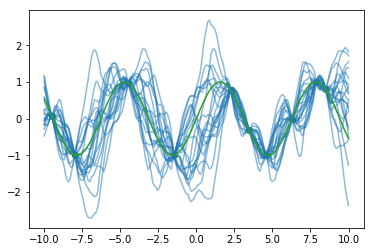

In [3]:
# GP regression
x_ind = random.sample(set(range(xs.shape[0])), 10)
x_context = xs[x_ind]

# fit GP on context points
y_true = np.sin(x_context)

gp.fit(x_context.reshape((-1, 1)), y_true)

#sample new points from fitted GP
y_samples_new = gp.sample_y(xs.reshape((-1, 1)), n_samples=20, random_state=12)


#plot samples
#ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(y_samples_new.shape[1]):
  plt.plot(xs, y_samples_new[:,i], alpha = 0.5, c = ccycle[0])

plt.scatter(x_context, y_true, alpha = 1, c = ccycle[2])
plt.plot(xs, np.sin(xs), c = ccycle[2])
plt.show()



## NP as a prior over functions

In [4]:
tf.reset_default_graph()
sess = tf.Session()

xs = np.linspace(-1,1,200) 

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

#specify params for NP
params = NeuralProcessParams(dim_r = 10, dim_z = 7, n_hidden_units_h = [3], n_hidden_units_g = [10], learning_rate = 0.001)

train_op, loss = NeuralProcess(x_context=x_context, y_context=y_context, x_target=x_target, y_target=y_target
, params = params, n_draws = 10, noise_std=0.01)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

predictNP_op = predictNP(x_target = xs.reshape((-1,1)), params = params, n_draws=50)
y_star_mat = sess.run(predictNP_op.mu)



Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.cast instead.


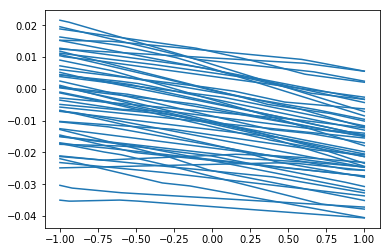

In [5]:
plt.plot(xs, y_star_mat, c = ccycle[0])
plt.show()


In [6]:
dim_z_vals = [1, 4, 8, 64]

y_stars = []

for dim_z_int, dim_z in enumerate(dim_z_vals):
    xs = np.linspace(-10,10,200) 

    params = NeuralProcessParams(dim_r = dim_z, dim_z = dim_z
                                 , n_hidden_units_h = [8], n_hidden_units_g = [8]
                                 , learning_rate = 0.001)
    sess = initializeNP(params)
    
    predictNP_op = predictNP(x_target = xs.reshape((-1,1)), params = params, n_draws=20, noise_std=0)
    y_stars.append(sess.run(predictNP_op.mu))
    


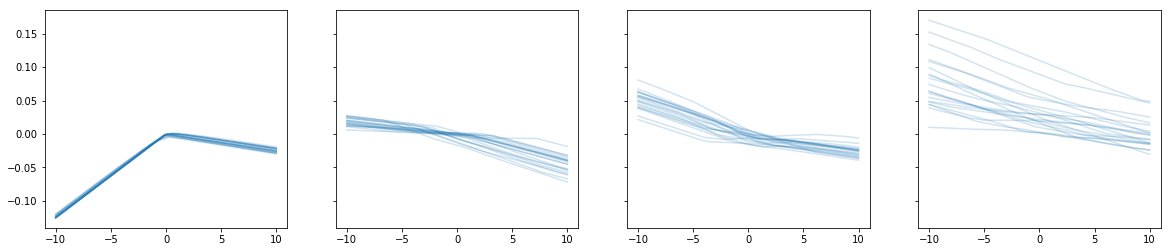

In [7]:
fig, axes = plt.subplots(ncols=4, nrows=1, sharey=True, figsize = (20, 4))

for i in range(len(y_stars)):
    y_stars_i = y_stars[i].T
    for j in range(y_stars_i.shape[0]):
        axes[i].plot(xs, y_stars_i[j], c=ccycle[0], alpha=0.2)

## Fit simple model with NPs

In [8]:
#xs = random.uniform(a=-10,b-10) 

# function generation
## sample kernel params
## sample function with kernel params

# sample random number of context points
# predict y_star of all points and calculate loss

params = NeuralProcessParams(dim_r = dim_z, dim_z = dim_z
                                 , n_hidden_units_h = [20,10], n_hidden_units_g = [20,10]
                                 , learning_rate = 0.001)

#generate points
n_obs = 5
#xs = np.random.uniform(-1, 1, n_obs)
xs = np.linspace(-1,1,n_obs)
ys = np.sin(3*xs)
x_star = np.linspace(-1,1,200) 

#initialize session
tf.reset_default_graph()
sess = tf.Session()

x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

train_op, loss = NeuralProcess(x_context=x_context, y_context=y_context
                               , x_target=x_target, y_target=y_target
                               , params=params
                               , n_draws=5)

# Initialize
init = tf.global_variables_initializer()
sess.run(init)

predict_op = predictNP(x_target = x_star.reshape((-1,1))
                         , x_context = xs.reshape((-1,1))
                         , y_context = ys.reshape((-1,1))
                         , params = params, n_draws=7, noise_std=0.05)

#specify number of iterations
n_iter = 25000
y_stars = []

for i in range(n_iter):
    
    #randomly sample context set
    n_context = np.random.choice(range(1, n_obs + 1), size=1)[0]
    feed_dict = split_context_target(xs.reshape((-1,1)), ys.reshape((-1,1)), n_context, x_context, y_context, x_target, y_target)
    
    # training step with randomly sampled context points
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    
    # predict every 1000 iterations
    if i % (n_iter/10) == 0:
        print('iteration ' + str(i))
        y_stars.append(sess.run(predict_op.mu))


iteration 0
iteration 2500
iteration 5000
iteration 7500
iteration 10000
iteration 12500
iteration 15000
iteration 17500
iteration 20000
iteration 22500


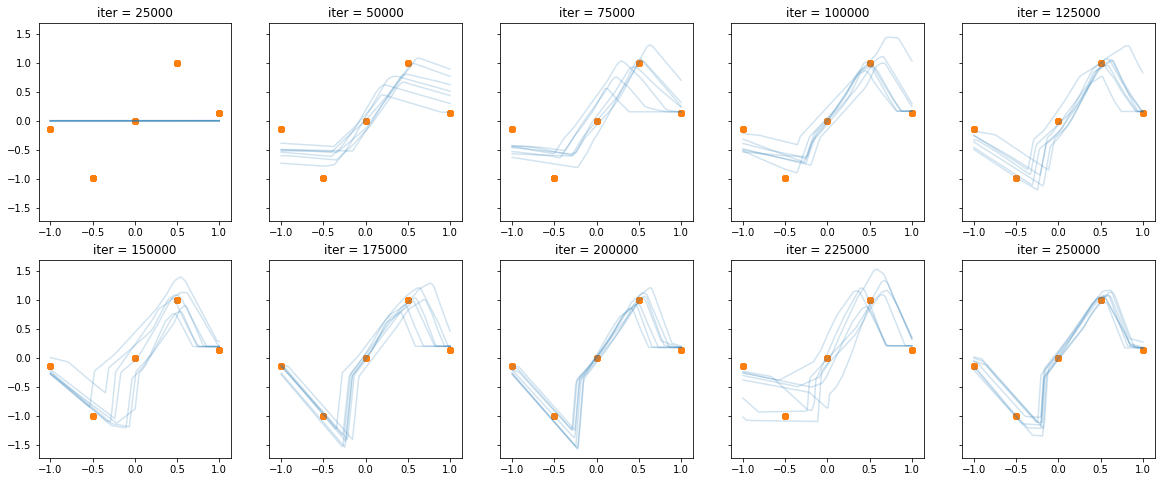

In [9]:
fig, axes = plt.subplots(ncols=5, nrows = 2, sharey=True, figsize = (20, 8))

for i in range(len(y_stars)):
    y_stars_i = y_stars[i].T
    for j in range(y_stars_i.shape[0]):
        ax1 = int(i / 5 >= 1)
        ax2 = i - (ax1 * 5)
        
        axes[ax1,ax2].plot(x_star, y_stars_i[j], c=ccycle[0], alpha=0.2)
        axes[ax1,ax2].set_title('iter = {}'.format((i+1)*n_iter))
        axes[ax1,ax2].scatter(xs, ys, c = ccycle[1])
        

In [10]:
len(y_stars)

10

   ## Vary number of training points

In [11]:
params = NeuralProcessParams(dim_r = 3, dim_z = 3
                                 , n_hidden_units_h = [20,10], n_hidden_units_g = [20,10]
                                 , learning_rate = 0.001)


#specify number of iterations
n_iter = 10000
y_stars = []

#generate points
n_obs = [5, 10, 25, 100]
xs_all = np.random.uniform(-1, 1, max(n_obs))
#xs = np.linspace(-1,1,n_obs)

x_star = np.linspace(-1,1,200) 

for p, val in enumerate(n_obs):
    
    xs = xs_all[0:val]
    ys = np.sin(3*xs)

    #initialize session
    tf.reset_default_graph()
    sess = tf.Session()

    x_context = tf.placeholder(tf.float32, (None, 1))
    y_context = tf.placeholder(tf.float32, (None, 1))
    x_target = tf.placeholder(tf.float32, (None, 1))
    y_target = tf.placeholder(tf.float32, (None, 1))

    train_op, loss = NeuralProcess(x_context=x_context, y_context=y_context
                                   , x_target=x_target, y_target=y_target
                                   , params=params
                                   , n_draws=5)

    # Initialize
    init = tf.global_variables_initializer()
    sess.run(init)

    predict_op = predictNP(x_target = x_star.reshape((-1,1))
                             , x_context = xs.reshape((-1,1))
                             , y_context = ys.reshape((-1,1))
                             , params = params, n_draws=7, noise_std=0.05)


    for i in range(n_iter):

        #randomly sample context set
        n_context = np.random.choice(range(1, val + 1), size=1)[0]
        feed_dict = split_context_target(xs.reshape((-1,1)), ys.reshape((-1,1)), n_context, x_context, y_context, x_target, y_target)

        # training step with randomly sampled context points
        a = sess.run((train_op, loss), feed_dict=feed_dict)
        
        if i % (n_iter/10) == 0:
            print('iteration ' + str(i))
        
    y_stars.append(sess.run(predict_op.mu))
        

iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


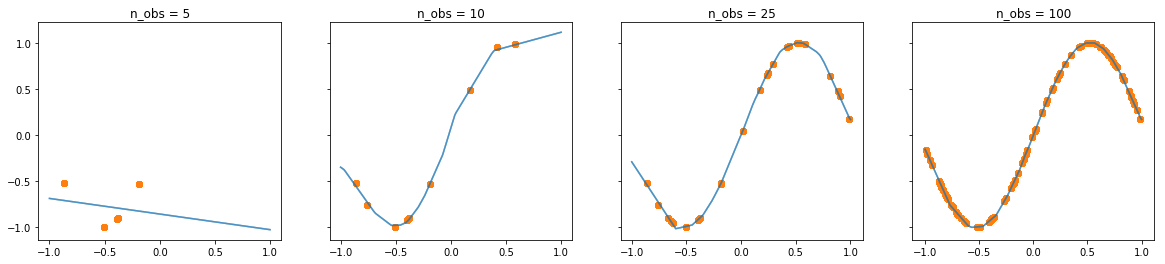

In [12]:
fig, axes = plt.subplots(ncols=4, nrows = 1, sharey=True, figsize = (20, 4))

for i in range(len(y_stars)):
    y_stars_i = y_stars[i].T
    for j in range(y_stars_i.shape[0]):
        
        axes[i].plot(x_star, y_stars_i[i], c=ccycle[0], alpha=0.2)
        axes[i].set_title('n_obs = {}'.format(n_obs[i]))
        axes[i].scatter(xs_all[0:n_obs[i]], np.sin(3*xs_all[0:n_obs[i]]), c = ccycle[1])
        
plt.show()

## Fit distribution of functions

$$f(x) = \sin(ax)$$
$$a \sim \mathcal{U}(-3,3)$$



In [86]:
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[32], n_hidden_units_g=[32], learning_rate = 0.001)

tf.reset_default_graph()

sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))


train_op, loss = NeuralProcess(x_context=x_context, y_context=y_context
                               , x_target=x_target, y_target=y_target
                               , params=params
                               , n_draws=7
                               #, noise_std = 1
                              )


# Initialize
init = tf.global_variables_initializer()
sess.run(init)

#specify number of iterations
n_iter = 50000
y_stars = []

for i in range(n_iter):
    
    #generate points
    n_obs = 50
    xs = np.random.uniform(-3, 3, n_obs)   #randomly spaced X
    #xs = np.linspace(-1,1,n_obs)          #fixed-width X
    a = random.uniform(-2,2)
    ys = a*np.sin(xs)

    
    #randomly sample context set
    n_context = random.choice(range(1, int(n_obs/2 + 1)))
    feed_dict = split_context_target(xs.reshape(-1, 1)
                                     , ys.reshape(-1, 1)
                                     , n_context, x_context, y_context, x_target, y_target)
    
    # training step with randomly sampled context points
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    
    # predict every 1000 iterations
    if i % (n_iter/10) == 0:
        print('iteration ' + str(i) + str('\t loss ') + str(a[1]))
        

        

iteration 0	 loss -31.131584
iteration 5000	 loss 13129.333
iteration 10000	 loss 14415.13
iteration 15000	 loss 2673.5337
iteration 20000	 loss 80.718544
iteration 25000	 loss 844.03033
iteration 30000	 loss 1462.8148
iteration 35000	 loss 1991.7249
iteration 40000	 loss 2994.9827
iteration 45000	 loss 1750.5652


In [87]:
z1s = np.arange(-4, 5)
z2s = np.arange(-4, 5)
# Sampls of Z are taken by using fixed 'random' values that get multipled with the distribution's std
eps_value = np.asarray(list(itertools.product(z1s, z2s)))
eps = tf.constant(eps_value, dtype=tf.float32)

x_star = np.linspace(-3,3,100) 

predict_op = predictNP(x_target = x_star.reshape((-1,1))
                       , params = params
                       , epsilon = eps)

y_star_prior = sess.run((predict_op.mu)).reshape((-1, len(z1s), len(z1s)))

epsilon


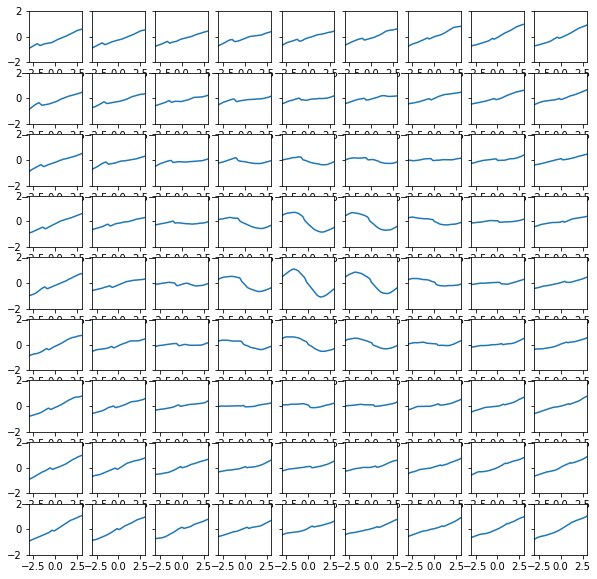

In [88]:
fig, axes = plt.subplots(ncols=len(z1s), nrows = len(z2s), sharey=True, figsize = (10, 10)
                        )

for i in range(y_star_prior.shape[1]):
    for j in range(y_star_prior.shape[2]):
        axes[i,j].plot(x_star, y_star_prior[:,i,j])
        axes[i,j].set_xlim((-3, 3))
        axes[i,j].set_ylim((-2, 2))

In [108]:
xs_pred = np.array([0,1,2,-1,-2])

n_pred_points = [1,3,5]

y_star_post = []

for p in n_pred_points:
    
    predict_post_op = predictNP(x_target = x_star.reshape((-1,1)) 
                            , params = params
                            , x_context = xs_pred[0:p,].reshape((-1,1))
                            , y_context = np.sin(xs_pred[0:p,]).reshape((-1,1))
                            , n_draws = 100)
    y_star_post.append(sess.run((predict_post_op.mu)))

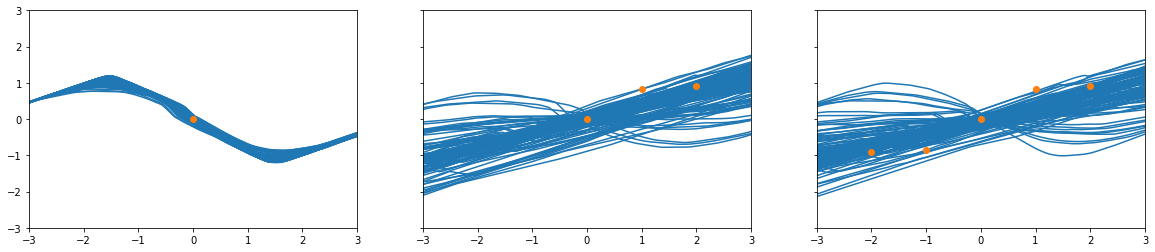

In [109]:
fig, axes = plt.subplots(ncols=3, nrows = 1, sharey=True, figsize = (20, 4))

for p, val in enumerate(n_pred_points):
    axes[p].set_xlim((-3, 3))
    axes[p].set_ylim((-3, 3))

    for i in range(y_star_post[p].shape[1]):
        axes[p].plot(x_star, y_star_post[p][:,i], c = ccycle[0], alpha = 0.2)
        
    axes[p].scatter(xs_pred[0:val], np.sin(xs_pred[0:val,]), c = ccycle[1], zorder = 100)

plt.show()

In [103]:
y_star_post[p].shape

(100, 50)

## NP on polynomials

In [165]:
#f(x) = b_0 + b_1 * x + b_2 * x^2 + b_3 * x^3
def getPoly(x,beta):
    return beta[0] + (beta[1] * x) + (beta[2] * np.power(x,2)) + (beta[3] * np.power(x,3))

params = NeuralProcessParams(dim_r=10
                             , dim_z=10
                             , n_hidden_units_h=[64,64,32,32]
                             , n_hidden_units_g=[32,64,32]
                             , learning_rate = 0.001)

tf.reset_default_graph()

sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))


train_op, loss = NeuralProcess(x_context=x_context, y_context=y_context
                               , x_target=x_target, y_target=y_target
                               , params=params
                               , n_draws=7
                               #, noise_std = 1
                              )

# Initialize
init = tf.global_variables_initializer()
sess.run(init)

#specify number of iterations
n_iter = 200000

for i in range(n_iter):
    
    #generate points
    n_obs = 50
    
    betas = np.random.normal(size=4, loc=0, scale=1) * np.random.binomial(1,0.5,4)
    xs = np.random.uniform(-3, 3, n_obs)   #randomly spaced X
    ys = getPoly(xs,betas)
    
    #randomly sample context set
    n_context = random.choice(range(1, int(n_obs/2 + 1)))
    feed_dict = split_context_target(xs.reshape(-1, 1)
                                     , ys.reshape(-1, 1)
                                     , n_context, x_context, y_context, x_target, y_target)
    
    # training step with randomly sampled context points
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    
    # predict every 1000 iterations
    if i % (n_iter/10) == 0:
        print('iteration ' + str(i) + str('\t loss ') + str(a[1]))
        



iteration 0	 loss 19843.445
iteration 20000	 loss 29353.393
iteration 40000	 loss 31685.533
iteration 60000	 loss 27109.35
iteration 80000	 loss 1140089.5
iteration 100000	 loss 1578721.8
iteration 120000	 loss 15198.308
iteration 140000	 loss 188141.28
iteration 160000	 loss 27596.96
iteration 180000	 loss 5185.3467


In [166]:
xs_pred = np.linspace(-3,3,100)
np.random.shuffle(xs_pred)

n_pred_points = [25,50,75,100]

y_star_post = []

for p in n_pred_points:
    
    predict_post_op = predictNP(x_target = x_star.reshape((-1,1)) 
                            , params = params
                            , x_context = xs_pred[0:p,].reshape((-1,1))
                            , y_context = getPoly(xs_pred[0:p,], betas).reshape((-1,1))
                            , n_draws = 100)
    y_star_post.append(sess.run((predict_post_op.mu)))

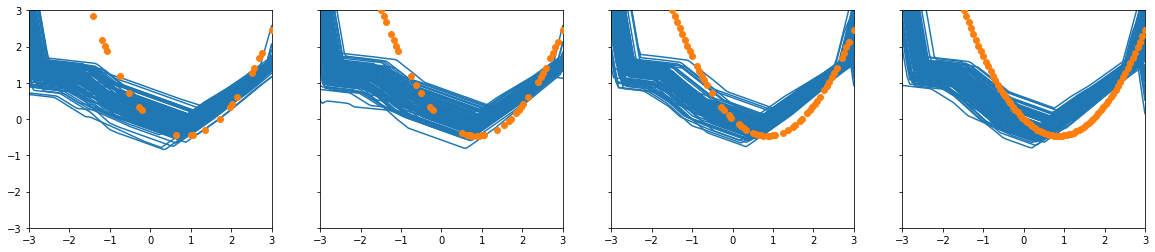

In [167]:
fig, axes = plt.subplots(ncols=4, nrows = 1, sharey=True, figsize = (20, 4))

for p, val in enumerate(n_pred_points):
    axes[p].set_xlim((-3, 3))
    axes[p].set_ylim((-3, 3))

    for i in range(y_star_post[p].shape[1]):
        axes[p].plot(x_star, y_star_post[p][:,i], c = ccycle[0])
        
    axes[p].scatter(xs_pred[0:val], getPoly(xs_pred[0:val,], betas), c = ccycle[1], zorder = 100)

plt.show()

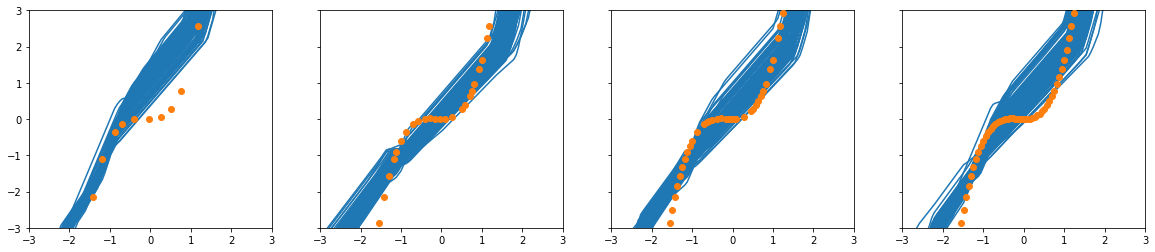

In [168]:
xs_pred = np.linspace(-3,3,100)
np.random.shuffle(xs_pred)
betas = np.random.normal(size=4, loc=0, scale=1) * np.random.binomial(1,0.5,4)

n_pred_points = [25,50,75,100]

y_star_post = []

#get predictions
for p in n_pred_points:
    
    predict_post_op = predictNP(x_target = x_star.reshape((-1,1)) 
                            , params = params
                            , x_context = xs_pred[0:p,].reshape((-1,1))
                            , y_context = getPoly(xs_pred[0:p,], betas).reshape((-1,1))
                            , n_draws = 100)
    y_star_post.append(sess.run((predict_post_op.mu)))
    
# do plot    
fig, axes = plt.subplots(ncols=4, nrows = 1, sharey=True, figsize = (20, 4))

for p, val in enumerate(n_pred_points):
    axes[p].set_xlim((-3, 3))
    axes[p].set_ylim((-3, 3))

    for i in range(y_star_post[p].shape[1]):
        axes[p].plot(x_star, y_star_post[p][:,i], c = ccycle[0])
        
    axes[p].scatter(xs_pred[0:val], getPoly(xs_pred[0:val,], betas), c = ccycle[1], zorder = 100)

plt.show()

In [164]:
(np.random.normal(size=4, loc=0, scale=1) * np.random.binomial(1,0.5,4))

array([0.       , 1.4247701, 0.       , 0.       ])